## 小斜视角RDA点目标成像

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

from numpy import pi,abs,max,min,argmax,argmin,ceil,exp,sqrt,real,imag,conj,sinc,sin,cos,tan,arctan,log10,angle,unwrap
from numpy import linspace,arange,zeros,ones,concatenate,convolve
from numpy.fft import fft,fftshift,ifft,ifftshift,fft2
from matplotlib.pyplot import figure,subplot,plot,axis,title,suptitle,xlabel,ylabel,text,arrow,tight_layout

In [2]:
######################################
#            小斜视角（3.5°）
#                RDA
#              点目标仿真
######################################

# --------------------------------------------------------------------
# 定义参数
# --------------------------------------------------------------------
R_nc = 20e3;                # 景中心斜距
Vr = 150;                   # 雷达有效速度
Tr = 2.5e-6;                # 发射脉冲时宽
Kr = 20e12;                 # 距离调频率
f0 = 5.3e9;                 # 雷达工作频率
BW_dop = 80;                # 多普勒带宽
Fr = 60e6;                  # 距离采样率
Fa = 200;                   # 方位采样率
Naz = 1024;                 # 距离线数（即数据矩阵，行数）——这里修改为1024。
Nrg = 320;                  # 距离线采样点数（即数据矩阵，列数）
sita_r_c = (3.5*pi)/180;	# 波束斜视角，3.5 度，这里转换为弧度
c = 3e8;                    # 光速

R0 = R_nc*cos(sita_r_c);	# 与R_nc相对应的最近斜距，记为R0
Nr = int(Tr*Fr);                 # 线性调频信号采样点数
BW_range = Kr*Tr;           # 距离向带宽
lamda0 = c/f0;               # 波长
fnc = 2*Vr*sin(sita_r_c)/lamda0;     # 多普勒中心频率，根据公式（4.33）计算。
La_real = 0.886*2*Vr*cos(sita_r_c)/BW_dop; # 方位向天线长度，根据公式（4.36）
beta_bw = 0.886*lamda0/La_real;              # 雷达3dB波束     
La = 0.886*R_nc*lamda0/La_real;              # 合成孔径长度
a_sr = Fr / BW_range;       # 距离向过采样因子
a_sa = Fa / BW_dop;         # 方位向过采样因子

Mamb = round(fnc/Fa);       # 多普勒模糊

NFFT_r = Nrg;               # 距离向FFT长度
NFFT_a = Naz;               # 方位向FFT长度

R_ref = R0;             # 参考目标选在场景中心，其最近斜距为 R_ref
fn_ref = fnc;        	# 参考目标的多普勒中心频率

# --------------------------------------------------------------------
# 设定仿真点目标的位置
# 以距离向作为x轴正方向
# 以方位向作为y轴正方向
# -------------------------------------------------------------------- 
delta_R0 = 0;       # 将目标1的波束中心穿越时刻，定义为方位向时间零点。
delta_R1 = 120; 	# 目标1和目标2的方位向距离差，120m
delta_R2 = 50;      # 目标2和目标3的距离向距离差，50m

# 目标1
x1 = R0;            # 目标1的距离向距离
y1 = delta_R0 + x1*tan(sita_r_c);	# 目标1的方位向距离

# 目标2
x2 = x1;            # 目标2和目标1的距离向距离相同
y2 = y1 + delta_R1; # 目标2的方位向距离
# 目标3
x3 = x2 + delta_R2;                 # 目标3和目标2有距离向的距离差，为delta_R2
y3 = y2 + delta_R2*tan(sita_r_c);  	# 目标3的方位向距离
# 定义以下数组，便于处理
x_range = [x1,x2,x3];
y_azimuth = [y1,y2,y3];

# 计算三个目标各自的波束中心穿越时刻
nc_1 = (y1-x1*tan(sita_r_c))/Vr;    # 目标1的波束中心穿越时刻。
nc_2 = (y2-x2*tan(sita_r_c))/Vr;    # 目标2的波束中心穿越时刻。
nc_3 = (y3-x3*tan(sita_r_c))/Vr;    # 目标3的波束中心穿越时刻。
nc_target = [nc_1,nc_2,nc_3];       # 定义该数组，便于处理。

In [3]:
## 
# --------------------------------------------------------------------
# 距离（方位）向时间，频率相关定义
# --------------------------------------------------------------------
# 距离
tr = 2*R0/c + arange( -Nrg/2,Nrg/2,1 )/Fr;                # 距离时间轴
fr = arange( -NFFT_r/2 ,NFFT_r/2,1 )*( Fr/NFFT_r );          # 距离频率轴
# 方位
ta = arange( -Naz/2,Naz/2,1 )/Fa;                            # 方位时间轴
fa = fnc + arange( -NFFT_a/2 , NFFT_a/2,1 )*( Fa/NFFT_a );	# 方位频率轴

# 生成距离（方位）时间（频率）矩阵
tr_mtx = np.matmul(ones((Naz,1)),tr.reshape((1,Nrg)));    # 距离时间轴矩阵，大小：Naz*Nrg
ta_mtx = np.matmul(ta.reshape((Naz,1)),ones((1,Nrg)));  # 方位时间轴矩阵，大小：Naz*Nrg
fr_mtx = np.matmul(ones((Naz,1)),fr.reshape((1,Nrg)));    # 距离频率轴矩阵，大小：Naz*Nrg
fa_mtx = np.matmul(fa.reshape((Naz,1)),ones((1,Nrg)));  # 方位频率轴矩阵，大小：Naz*Nrg

## 
# --------------------------------------------------------------------
# 生成点目标原始数据
# --------------------------------------------------------------------
s_echo = zeros((Naz,Nrg),dtype='complex');    # 用来存放生成的回波数据

A0 = 1;                     # 目标回波幅度，都设置为1.
for k in range(1):                 # 生成k个目标的原始回波数据
    R_n = sqrt( (x_range[k]*ones((Naz,Nrg)))**2 + (Vr*ta_mtx-y_azimuth[k]*ones((Naz,Nrg)))**2 );# 目标k的瞬时斜距
    w_range = np.where( (abs(tr_mtx-2*R_n/c) <= (Tr/2)*ones((Naz,Nrg))),1,0);     # 距离向包络，即距离窗
    # =====================================================================    
    # 方位向包络，也就是 天线的双程方向图作用因子。
    #{
    # 方式1
    # sinc平方型函数，根据公式（4.31）计算    
#     sita = arctan( Vr*(ta_mtx-nc_target[k]*ones((Naz,Nrg)))/x_range[k] );
#     w_azimuth1 = (sinc(0.886*sita/beta_bw))**2;    
    # 用每个目标对应的 波束中心穿越时刻，而不是之前参数中的nc。
    #}
    #
    # 方式2
    # 利用合成孔径长度，直接构造矩形窗（其实这里只是限制数据范围，没有真正加窗）
    w_azimuth = np.where(abs(ta - nc_target[k]) <= (La/2)/Vr,1,0);    # 行向量
    w_azimuth = np.matmul(w_azimuth.reshape((Naz,1)),ones((1,Nrg)));    # 生成Naz*Nrg的矩阵
    #}
# =====================================================================     
    s_k = A0*w_range*w_azimuth*exp(-(1j*4*pi*f0)*R_n/c)*exp((1j*pi*Kr)*(tr_mtx-2*R_n/c)**2);
#     s_k = A0.*w_range.*w_azimuth1.*w_azimuth.*exp(-(1j*4*pi*f0).*R_n./c).*exp((1j*pi*Kr).*(tr_mtx-2.*R_n./c).^2);
    # 上式就是生成的某一个点目标（目标k）的回波信号。
    # 经过几次循环，生成几个点目标的回波信号，相加即可。
    if k == 1:
        s_1 = s_k;          # 目标1的回波信号

    if k == 2:   
        s_2 = s_k;          # 目标2的回波信号

    if k == 3:
        s_3 = s_k;          # 目标3的回波信号

    s_echo = s_echo + s_k;  # 所有点目标回波信号之和   

# s_echo 就是我们需要的原始数据，点目标回波信号。


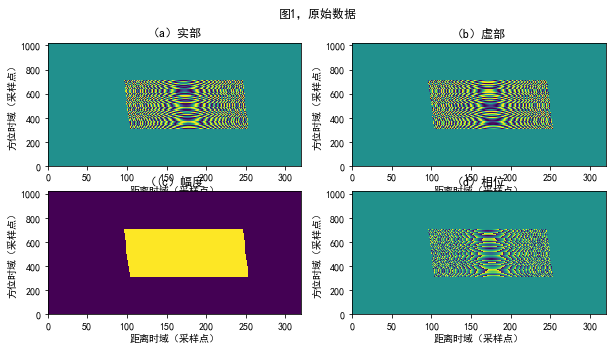

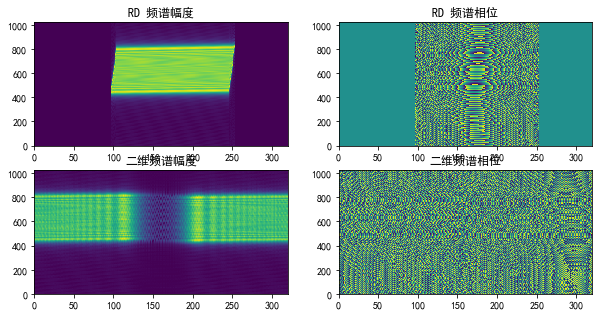

In [4]:
# 作图
# 图1——原始数据
figure(figsize=(10,5));
subplot(2,2,1);
plt.pcolor(real(s_echo));
title('（a）实部');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');
suptitle('图1，原始数据');       # 给图1进行文字说明 
# text 函数：在图像的指定坐标位置，添加文本框

subplot(2,2,2);
plt.pcolor(imag(s_echo));
title('（b）虚部');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');

subplot(2,2,3);
plt.pcolor(abs(s_echo));
title('（(c）幅度');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');

subplot(2,2,4);
plt.pcolor(angle(s_echo));
title('（d）相位');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');
# colormap(gray);


figure(figsize=(10,5));
subplot(2,2,1);
plt.pcolor(abs(fft(s_echo,axis=0)));
title('RD 频谱幅度');
subplot(2,2,2);
plt.pcolor(angle(fft(s_echo,axis=0)));
title('RD 频谱相位');
subplot(2,2,3);
plt.pcolor(abs(fft2(s_echo)));
title('二维频谱幅度');
subplot(2,2,4);
plt.pcolor(angle(fft2(s_echo)));
title('二维频谱相位');
# colormap(gray);

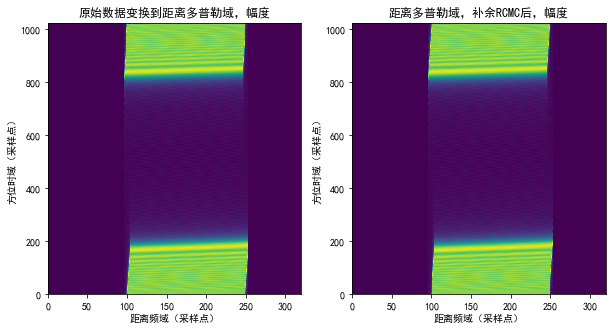

In [7]:
# --------------------------------------------------------------------
# 变换到距离多普勒域，进行“补余RCMC”
# --------------------------------------------------------------------
s_rd = s_echo*exp(-1j*2*pi*fnc*(ta.reshape((Naz,1))*ones((1,Nrg)))); 	# 数据搬移

S_RD = fft(s_rd,NFFT_a,axis=0);  # 进行方位向傅里叶变换，得到距离多普勒域频谱

D_fn_Vr = sqrt(1-lamda0**2*fa**2/(4*Vr**2));     # 大斜视角下的徙动因子，列向量
D_fn_Vr_mtx = D_fn_Vr.reshape((Naz,1))*ones((1,Nrg));  # 形成矩阵，大小：Nrg*Naz

D_fn_ref_Vr = sqrt(1-lamda0**2*fn_ref**2/(4*Vr**2));    # 参考频率fn_ref处的徙动因子，是常数。

K_src = 2*Vr**2*f0**3*D_fn_Vr**3./(c*R_ref*fa**2);   # 列向量，使用R_ref处的值 
K_src_mtx = K_src.reshape((Naz,1))*ones((1,Nrg));  # 形成矩阵
Km = Kr/(1-Kr/K_src_mtx);     # 矩阵，这是变换到距离多普勒域的距离调频率。
                                # 使用 R_ref 处的值

# 下面生成 变标方程 s_sc
s_sc = exp(1j*pi*Km*(D_fn_ref_Vr/D_fn_Vr_mtx-1)*(tr_mtx-2*R_ref/(c*D_fn_Vr_mtx))**2);

# 下面将距离多普勒域的信号与变标方程相乘，实现“补余RCMC”
S_RD_1 = S_RD*s_sc;            # 相位相乘，实现“补余RCMC”

#
# 作图
figure(figsize=(10,5));
subplot(1,2,1);
plt.pcolor(abs(S_RD));
title('原始数据变换到距离多普勒域，幅度');
xlabel('距离频域（采样点）');
ylabel('方位时域（采样点）');

subplot(1,2,2);
plt.pcolor(abs(S_RD_1));
title('距离多普勒域，补余RCMC后，幅度');
xlabel('距离频域（采样点）');
ylabel('方位时域（采样点）');
#}

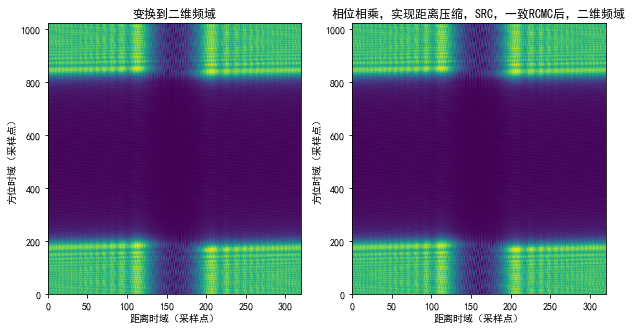

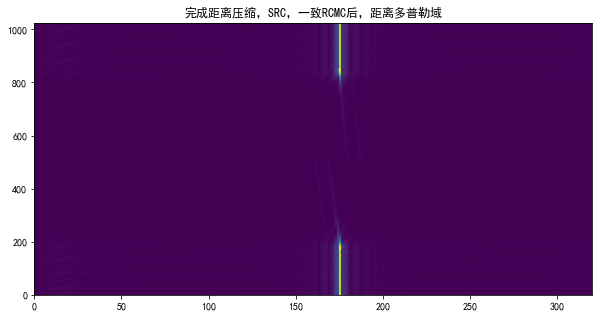

In [18]:
# --------------------------------------------------------------------
# 变换到二维频域，进行“距离压缩，SRC，一致RCMC”
# --------------------------------------------------------------------
S_2df_1 = fft(S_RD_1,NFFT_r,axis=1);         # 进行距离向FFT，变换到二维频域。距离零频在两端

# 完成距离压缩，SRC，一致RCMC这三者相位补偿的滤波器为：
H1 = exp(1j*pi*D_fn_Vr_mtx/(D_fn_ref_Vr*Km)*fr_mtx**2);
H2 = exp(1j*4*pi/c*(1/D_fn_Vr_mtx-1/D_fn_ref_Vr)*R_ref*fr_mtx);
H = H1*H2
# 上面的H距离零频在中心
window = np.kaiser(Nrg,3)
W_ref = ones((Naz,1))*window.reshape((1,Nrg));	# 距离向，构建Kaiser窗，此为矩阵形式，距离零频在中心。
# H1 = W_ref.*H1;             # 加入距离平滑窗，以抑制旁瓣，距离零频在中心。
# 下面通过fftshift将H1的距离零频调整到两端
H1 = fftshift(H);        # 左右半边互换，距离零频在两端。
# H1 = zeros((Naz,Nrg))
# for i in range(Naz):
#     H1[i,:] = fftshift(H[i,:])

S_2df_2 = S_2df_1*H1;    	# 在二维频域，相位相乘，实现距离压缩，SRC，一致RCMC

S_RD_2 = ifft(S_2df_2,NFFT_r,axis=1);    # 进行距离IFFT，回到距离多普勒域，完成所有距离处理。

# 作图
figure(figsize=(10,5));
subplot(1,2,1);
plt.pcolor(abs(S_2df_1));  #　这及其以下，都直接使用去除弃置区后的结果
title('变换到二维频域');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');
#suptitle('图4，二维时域');       # 给图4进行文字说明
#text(172,-10,'完成压缩');       

subplot(1,2,2);
plt.pcolor(abs(S_2df_2));
title('相位相乘，实现距离压缩，SRC，一致RCMC后，二维频域');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');

figure(figsize=(10,5));
plt.pcolor(abs(S_RD_2));  #　这及其以下，都直接使用去除弃置区后的结果
title('完成距离压缩，SRC，一致RCMC后，距离多普勒域');

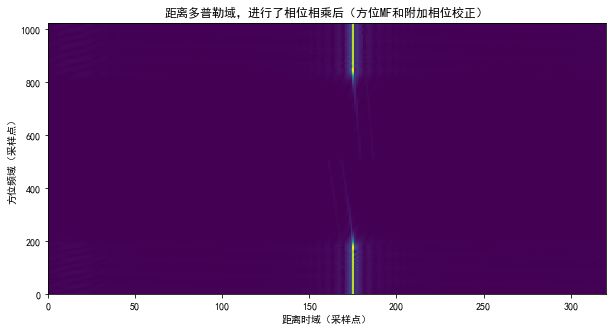

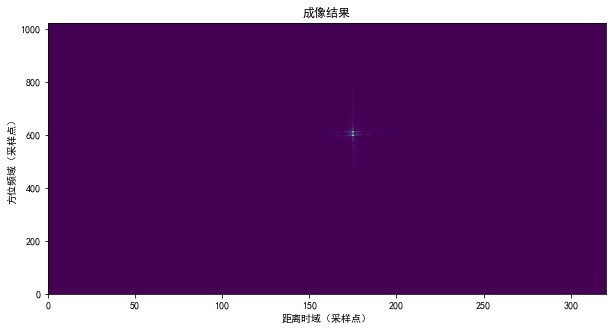

In [19]:
# --------------------------------------------------------------------
# 距离多普勒域，完成“方位压缩”和“附加相位校正”
# --------------------------------------------------------------------
R0_RCMC = (c/2)*tr;   # 随距离线变化的R0，记为R0_RCMC，用来计算方位MF。
# 生成方位向匹配滤波器
Haz = exp(1j*4*pi*(D_fn_Vr.reshape((Naz,1))*R0_RCMC.reshape((1,Nrg)))*f0/c);       # 方位MF

# 附加相位校正项
H2 = exp(-1j*4*pi*Km/(c**2)*(1-D_fn_Vr_mtx/D_fn_ref_Vr)*((1/D_fn_Vr).reshape((Naz,1))*R0_RCMC.reshape((1,Nrg))-R_ref/D_fn_Vr_mtx)**2); 	# 附加相位校正项

# 下面进行相位相乘，在距离多普勒域，同时完成方位MF和附加相位校正
S_RD_3 = S_RD_2*Haz*H2;           # 距离多普勒域，相位相乘

# 最后通过IFFT回到图像域，完成方未处理
s_image = ifft(S_RD_3,NFFT_a,axis=0); 	# 完成成像过程，得到成像结果为：s_image

# 作图
figure(figsize=(10,5));
plt.pcolor(abs(S_RD_3));
title('距离多普勒域，进行了相位相乘后（方位MF和附加相位校正）');
xlabel('距离时域（采样点）');
ylabel('方位频域（采样点）');

figure(figsize=(10,5));
plt.pcolor(abs(s_image));
title('成像结果');
xlabel('距离时域（采样点）');
ylabel('方位频域（采样点）');


In [14]:
def performance(x,s_number,T):
#
# 针对函数 zhibiao(x,s_number,T) 进行改进，改进的内容主要为：
# 在计算3dB点所对应的坐标时——用来计算 分辨率（IRW）
# 函数 zhibiao() 中采用的是临近取整的办法，这不准确。
# 下面利用的方法是将离 3dB 最近的两个点进行线性插值，来得到更准确的3dB点所对应的坐标。
#
# 输入变量：信号x，采样点数 s_number，T是信号的时域长度。
# 该函数用来求解 x 的峰值旁瓣比(PSLR)，积分旁瓣比(ISLR),距离分辨率（IRW）。
    soo = x;                # 信号x
    N_buling = s_number;    # 采样点数

    soo_abs = abs(soo);     # soo的模
    I = argmax(soo_abs);   # 求输出 soo的模 中的最大值 C，位置 I；
    C = soo_abs[I]
    y = soo_abs**2;         # 输出的平方， y = soo^2。

    x1 = 0;
    while (soo_abs[I-x1-1]-soo_abs[I-x1])<0:
        M1 = x1;
        x1 = x1+1;
    x2 = 0;
    while (soo_abs[I+x2+1]-soo_abs[I+x2])<0:
        M2 = x2;
        x2 = x2+1;


    P1 = I-1-M1;            # 主瓣和旁瓣分界点，左边的坐标是 P1。
    P2 = I+1+M2;            # 主瓣和旁瓣分界点，右边的左边是 P2。

    D_left = max(soo_abs[:P1]);     # 最大旁瓣，值为 D_left，位置为 Q_left。（左边的那一个）。
                                  
    D_right = max(soo_abs[P2:]); # 最大旁瓣，值为 D_right，位置为 Q_right。（右边的那一个）。
    D = max([D_left,D_right]);    # 比较左边和右边两者中的最大值，得到两侧旁瓣中最大的旁瓣，值为 D。

    PSLR = 20*log10(D/C);                       # 峰值旁瓣比
    ISLR = 10*log10((sum(y[int(P1/20):P1])+sum(y[P2:]))/sum(y[P1:P2]));# 积分旁瓣比。

    #######################  以下是求 IRW  #########################
    M = ( 10**(-3/20) )*C;       # 3dB 带宽处的函数取值。
    # 下面是为了求找出与该函数值最接近的值的大小和坐标。
    z1 = abs(soo_abs[P1]-M);
    x1 = 0;
    z1_x1 = 0;
    for k1 in range(P1,I+1,1):
        cha1 = abs(soo_abs[P1+x1]-M);
        if cha1<z1:
            z1 = cha1;
            z1_x1 = x1; # z1_x1 是我们需要的，它的值是所求坐标与 P1 的偏移量。（左侧的）
        x1 = x1+1;


    z2 = abs(soo_abs[I]-M);
    x2 =0;
    z2_x2 = 0;
    for k2 in range(I,P2+1,1):
        cha2 = abs(soo_abs[I+x2]-M);
        if cha2<z2:
            z2 = cha2;
            z2_x2 = x2;# z2_x2 是我们需要的，它的值是所求坐标与 I 的偏移量。（右侧的）
        x2 = x2+1;
  

    Th_x1 = P1+z1_x1;# Th_x1 就是我们所求3dB带宽点左侧那个点的坐标（距离3dB最近的整数点）
    Th_x2 = I+z2_x2; # Th_x2 就是····3dB带宽点右侧······（距离3dB最近的整数点）
    # ------------------------------------------------------------------
    # 通过上面求得的距离3dB最近的整数点 Th_x1 和 Th_x2
    # 利用线性插值，得到3dB带宽所对应点数的更准确的值
    # 计算左边3dB的那个坐标
    if soo_abs[Th_x1]-M < 0:
        x0_linear = Th_x1;
        x1_linear = Th_x1+1;
    else:
        x0_linear = Th_x1-1;
        x1_linear = Th_x1;
 
    Th_x1_real = (M-soo_abs[x1_linear])/(soo_abs[x0_linear]-soo_abs[x1_linear])*x0_linear + (M-soo_abs[x0_linear])/(soo_abs[x1_linear]-soo_abs[x0_linear])*x1_linear;

    # 计算右边3dB的那个坐标
    if soo_abs[Th_x2]-M > 0:
        x0_linear = Th_x2;
        x1_linear = Th_x2+1;
    else:
        x0_linear = Th_x2-1;
        x1_linear = Th_x2;

    Th_x2_real = (M-soo_abs[x1_linear])/(soo_abs[x0_linear]-soo_abs[x1_linear])*x0_linear  + (M-soo_abs[x0_linear])/(soo_abs[x1_linear]-soo_abs[x0_linear])*x1_linear;
    # ------------------------------------------------------------------
    width = Th_x2_real-Th_x1_real;  # width 就是通过此种方法求得的 3dB带宽。

    c = 3e8;# 光速 c=3e8 m/s。
    IRW = T/N_buling*width*c/2;# 注意在SAR中，分辨率是 C*T/2,其中T是脉冲宽度。
    # IRW_real为图像分辨率，原来的width的单位是采样间隔。一般图像分辨率单位取 m，要转换。
    # 注意到采样点数用的是 N_buling，因为频域补零后等效为升采样，采样率提高，采样点数应该跟正为 N_buling。
    return PSLR,ISLR,IRW

In [15]:
# function [PSLR_r,ISLR_r,IRW_r, PSLR_a,ISLR_a,IRW_a] = target_analysis_2(s_ac,Fr,Fa,Vr)
# !pip install scikit-image
# from skimage.transform import rotate as imrotate
from scipy.ndimage import rotate
def target_analysis_2(s_ac,Fr,Fa,Vr):
# 截止到 2014.10.10 10:34 a.m.
# 
# 2014.10.10. 修改了： 指标计算函数采用更改后的: zhibiao_2( )
# 2014.10.10. 修改了： 二维补零方式更改为第 2 种方法：先对每列补零，再对每行补零。
#
# ===============================================================
# 该程序考虑了大斜视角下，对点目标的扭曲
# 分别考虑距离向和方位向
# 考虑距离向旋转角度，将距离向轴旋转到平行于水平轴，再取出行切片
# 考虑方位向旋转角度，将方位向轴旋转到平行于垂直轴，再取出列切片
# ===============================================================
#
# 输入变量： s_ac  ——是需要进行指标分析的点目标点k，s_ac是它所在的一块矩阵数据。
# 输入变量： Fr  —— 距离向采样率
# 输入变量： Fa  —— 方位向采样率
# 输入变量： Vr  —— 平台速度
# 该函数用来求解点目标k的各项指标
# 点目标中心的行切片（距离向）：峰值旁瓣比(PSLR)，积分旁瓣比(ISLR),距离分辨率（IRW）。
# 点目标中心的列切片（方位向）：峰值旁瓣比(PSLR)，积分旁瓣比(ISLR),距离分辨率（IRW）。
# 输出值分别是行切片和列切片的各项指标
#
# 补零方式很关键
# 这里采用的方法是逐行，逐列判断数据最小值位置，然后将在最小值位置处进行补零
#
########################################################
#       取点目标中心 NN*NN 切片，进行升采样
#   再取点目标中心，距离向切片，方位向切片，进行升采样
#                   计算各项性能指标
########################################################

    c = 3e8;                # 光速
    NN = 32;        # 切片总长度，NN*NN
    row,column = s_ac.shape;      # s_ac的矩阵大小
    p = argmax(abs(s_ac),axis=1); 
    v = max(abs(s_ac),axis=1);
    q = argmax(v);

    row_max    = p[q];      # 二维矩阵最大值，所在第几行—— row_max。
    column_max = q;         # 二维矩阵最大值，所在第几列—— column_max。
    s_ac_max   = v[q];      # 矩阵最大值是—— x_max。
    hNN = int(NN/2)
    rstart = max([row_max-hNN,0])
    rend   = min([row_max+hNN,row])
#     if( rend-rstart>=NN ): 
    rend = rstart+NN
    cstart = max([column_max-hNN,0])
    cend   = min([column_max+hNN,column])
#     if( cend-cstart>=NN ): 
    cend   = cstart+NN
    s_ac_test = s_ac[rstart:rend,cstart:cend];
    # 得到NN*NN的切片

    # 下面进行二维升采样
    S_ac_test_1 = fft(s_ac_test,axis   = 0);   # 方位向fft
    S_ac_test_2 = fft(S_ac_test_1,axis = 1);   # 距离向fft

    # 接下来进行二维补零
    # =========================================================================
    # 利用两个for循环，在每行和每列最小值的位置处补上7*NN的零，实现高频补零。
    #------------------------------------------------------------------
    #{
    # 第 1 种方法： 先对每行补零，再对每列补零。
#     S_ac_test_buling_1 = zeros((NN,8*NN),dtype='complex');  # 中间变量
#     S_ac_test_buling = zeros((8*NN,8*NN),dtype='complex');
#     # 下面先对每行补零，再对每列补零
#     for pp in range(NN):           # 在每行的最小值位置补零
#         I = argmin(abs(S_ac_test_2[pp,:]));
#         S_ac_test_buling_1[pp,:I+1] = S_ac_test_2[pp,:I+1];
#         S_ac_test_buling_1[pp,8*NN-(NN-I)+1:8*NN] = S_ac_test_2[pp,I+1:NN];

    # for qq = 1:8*NN         # 在每列的最小值位置补零
    #     [C,I] = min(S_ac_test_buling_1(:,qq));
    #     S_ac_test_buling(1:I,qq) = S_ac_test_buling_1(1:I,qq);
    #     S_ac_test_buling(8*NN-(NN-I)+1:8*NN,qq) = S_ac_test_buling_1(I+1:NN,qq);
    # end
    # 由于上面的在每列的最小值位置补零，得到的结果是有问题的，因此下面进行修改
    # 修改方法是：
    #       直接对每一列，在中间补零
#     NN2 = int(NN/2)
#     S_ac_test_buling[:NN2,:] = S_ac_test_buling_1[:NN2,:];
#     S_ac_test_buling[8*NN-NN2:8*NN,:] = S_ac_test_buling_1[NN2:NN,:];
#     np.savetxt('S_ac_test_buling.txt',S_ac_test_buling)
    #}
    #------------------------------------------------------------------
    #
    # 第 2 种方法： 先对每列补零，再对每行补零。
    S_ac_test_buling_1 = zeros((8*NN,NN),dtype='complex');  # 中间变量
    S_ac_test_buling = zeros((8*NN,8*NN),dtype='complex');
    # 下面先对每列补零，再对每行补零——注意：和上面的先行后列相比，这是有区别的。
    for pp in range(NN):          # 在每行的最小值位置补零
        I = argmin(abs(S_ac_test_2[:,pp]));
        S_ac_test_buling_1[:I+1,pp] = S_ac_test_2[:I+1,pp];
        S_ac_test_buling_1[8*NN-(NN-I)+1:8*NN,pp] = S_ac_test_2[I+1:NN,pp];

    for qq in range(8*NN):         # 在每列的最小值位置补零
        I = argmin(abs(S_ac_test_buling_1[qq,:]));
        S_ac_test_buling[qq,:I+1] = S_ac_test_buling_1[qq,:I+1];
        S_ac_test_buling[qq,8*NN-(NN-I)+1:8*NN] = S_ac_test_buling_1[qq,I+1:NN];
    #}
    #------------------------------------------------------------------
    # =========================================================================
    S_ac_test_1 = ifft(S_ac_test_buling,axis=1);
    s_ac_test = ifft(S_ac_test_1,axis=0);         # 完成二维升采样。
    # 作图
    figure(figsize=(10,5));
    plt.pcolor(abs(s_ac_test));
    title('将成像结果做升采样，看效果如何');

    ## 
    # 下面分别对点目标中心（二维最大值）做行切片，和列切片。
    # 每一个切片，都做 16倍 升采样。
    # 并分别作出归一化的对数幅度图。
    # -------------------------------------------------------
    # 考虑图像扭曲
    # 将目标进行旋转和扭曲，以使大部分旁瓣对齐至水平轴和垂直轴
    # -------------------------------------------------------

    ## 
    # 取出行切片

    # 第一步，找出升采样后点目标中心的位置和大小
    row_test,column_test = s_ac_test.shape;      # s_ac_test的矩阵大小
    p_test = argmax(abs(s_ac_test),axis=0);
    v_test = max(abs(s_ac_test),axis=0);
    q_test = argmax(v_test);

    row_test_max = p_test[q_test];      # 二维矩阵最大值，所在第几行—— row_max。
    column_test_max = q_test;           # 二维矩阵最大值，所在第几列—— column_max。
    s_ac_test_max = v_test[q_test];            # 矩阵最大值是—— x_max。
    # 第二步，找出点目标中心左侧2/3长度内的最大值，以此来计算距离旁瓣的扭曲角度
    # 注意到，如果直接在左侧2/3长度内寻找最大值，有可能会误判到方位旁瓣上的点；
    # 因此，由于斜视角的关系，左侧的距离旁瓣一定是向上倾斜的；
    # 因此下面的寻找中，行直接规定为在点目标中心所在行的上方。
    c3 = int(2*(column_test_max+1)/3)
    p_test_2 = argmax(abs(s_ac_test[:row_test_max+1,:c3]),axis=0);  
    v_test_2 = max(abs(s_ac_test[:row_test_max+1,:c3]),axis=0);
    q_test_2 = argmax(v_test_2);
    row_test_max_2 = p_test_2[q_test_2];  # 二维矩阵点目标中心左侧2/3长度的最大值，所在第几行
    column_test_max_2 = q_test_2;# 二维矩阵点目标中心左侧2/3长度的最大值，所在第几列
    
    # 第三步，计算距离旁瓣扭曲的转角
    range_theta = arctan( abs((row_test_max_2-row_test_max)/(column_test_max_2-column_test_max)) );
    
    # 结果是弧度，下面转成角度
    range_theta = range_theta/pi*180;   # 这是距离旁瓣扭曲的角度
#     print( 'range_theta:',range_theta )
    # 第四步，将升采样的结果s_ac_test以角range_theta进行旋转（这里是逆时针旋转）
    s_ac_range = rotate(s_ac_test,range_theta);# 采用'bilinear'，双线性插值的方式
    # s_ac_range是旋转后的图像
    # 距离向切片就以此来计算。

    # 作图
    figure(figsize=(10,5));
    plt.pcolor(abs(s_ac_range));
    title('将距离向旁瓣旋转到平行于水平轴后的成像结果');

    # 第五步，找出旋转后的最大值中心，并取出相应的行切片
    p_test_range = argmax(abs(s_ac_range),axis=0);    
    v_test_range = max(abs(s_ac_range),axis=0);  
    q_test_range = argmax(v_test_range);
    row_test_max_range = p_test_range[q_test_range]; # 旋转后，点目标中心，所在第几行
    column_test_max_range = q_test_range;  # 旋转后，点目标中心，所在第几列

    cm3 = int((column_test_max_range+1)/3)
    s_ac_test_row_max = s_ac_range[row_test_max_range,cm3:5*cm3];
    # s_ac_test_row_max是取出的点目标中心行切片。
    # 其中，这里并没有把s_ac_range的一行全部取出来，而是将最左右两侧的一部分去除了。

    # 下面进行16倍升采样
    S_AC_test_row_max_1 = fft(s_ac_test_row_max);   # 变换到频域
    slen = S_AC_test_row_max_1.size
    slen2 = int(slen/2)
    # -----------------------------------------------------------------------
    # 以下分别是两种补零方式：
    # 方式 1 ：在高频（中间）补零
    S_AC_test_row_max = concatenate((S_AC_test_row_max_1[:slen2],zeros(15*slen,dtype='complex'),S_AC_test_row_max_1[slen2:]));

    # 方式 2 ：在最小值处补15倍的零
    # S_AC_test_row_max = zeros(1,16*length(S_AC_test_row_max_1));
    # [C1,I1] = min(S_AC_test_row_max_1);
    # S_AC_test_row_max(1,1:I1) = S_AC_test_row_max_1(1,1:I1);
    # S_AC_test_row_max(1,16*length(S_AC_test_row_max_1)+1-(length(S_AC_test_row_max_1)-I1):end) = S_AC_test_row_max_1(1,I1+1:end);
    # ------------------------------------------------------------------------- 
    # 到这里为止，频域补零完成    
    s_ac_test_row_max = ifft(S_AC_test_row_max);  # 进行IFFT，回到时域，得到升采样过后的行切片。
    # 到这里为止，升采样完成

    # 下面做归一化的对数幅度图
    s_ac_test_row_max_abs = abs(s_ac_test_row_max);             # 取幅度
    s_ac_test_row_max_abs = 20*log10(s_ac_test_row_max_abs);    # 取对数
    s_ac_test_row_max_abs = s_ac_test_row_max_abs - max(s_ac_test_row_max_abs); # 归一化

    # 作图
    figure(figsize=(10,5));
    plot(s_ac_test_row_max_abs);
    title('点目标中心，行切片');
#     figure(figsize=(20,10));
#     plot(s_ac_test_column_max_abs);
#     title('点目标中心，列切片');


    ##
    # 取出列切片

    # 第一步，找出升采样后点目标中心的位置和大小
    # （这和取出行切片时相同）

    # 第二步，找出点目标中心上方（方位向）2/3长度内的最大值，以此来计算方位旁瓣的扭曲角度
    # 注意到，如果直接在上方2/3长度内寻找最大值，由于距离旁瓣较强，所以有可能会误判到距离旁瓣上的点；
    # 因此，由于斜视角的关系，上方的方位旁瓣一定是向右倾斜的；
    # 因此下面的寻找中，列直接规定为在点目标中心所在列的右侧。
    cm3 = int(2*row_test_max/3)
    p_test_3 = argmax(abs(s_ac_test[:cm3,column_test_max:-10]),axis=0); 
    v_test_3 = max(abs(s_ac_test[:cm3,column_test_max:-10]),axis=0);  
    q_test_3 = argmax(v_test_3);

    row_test_max_3 = p_test_3[q_test_3];  # 二维矩阵点目标中心上方2/3长度的最大值，所在第几行
    column_test_max_3 = q_test_3;# 二维矩阵点目标中心上方2/3长度的最大值，所在第几列，这里要注意！！
    # 注意：column_test_max_3 由于是直接在点目标中心所在列的右侧进行判断的，因此这里的值是相对于点目标中心所在列的相对值。

    # 第三步，计算方位旁瓣扭曲的转角
    azimuth_theta = arctan( abs((column_test_max_3)/(row_test_max_3-row_test_max)) );
    # 结果是弧度，下面转成角度
    azimuth_theta = azimuth_theta/pi*180;   # 这是方位旁瓣扭曲的角度
    # 第四步，将升采样的结果s_ac_test以角azimitu_theta进行旋转（这里是逆时针旋转）
    s_ac_azimuth = rotate(s_ac_test,azimuth_theta);# 采用'bilinear'，双线性插值的方式
    # s_ac_azimuth是旋转后的图像
    # 方位向切片就以此来计算。

    # 作图
    figure(figsize=(10,5));
    plt.pcolor(abs(s_ac_azimuth));
    title('将方位向旁瓣旋转到平行于垂直轴后的成像结果');

    # 第五步，找出旋转后的最大值中心，并取出相应的列切片
    p_test_azimuth = argmax(abs(s_ac_azimuth),axis=0);
    v_test_azimuth = max(abs(s_ac_azimuth),axis=0);
    q_test_azimuth = argmax(v_test_azimuth);
    row_test_max_azimuth = p_test_azimuth[q_test_azimuth]; # 旋转后，点目标中心，所在第几行
    column_test_max_azimuth = q_test_azimuth;  # 旋转后，点目标中心，所在第几列。
    cm3 = int((row_test_max_azimuth+1)/3)
    cm5 = int(5*(row_test_max_azimuth+1)/3)

    s_ac_test_column_max = s_ac_azimuth[cm3:cm5,column_test_max_azimuth];
#     s_ac_test_column_max = s_ac_azimuth[:,column_test_max_azimuth];
    # s_ac_test_column_max是取出的点目标中心列切片。
    # 其中，这里并没有把s_ac_azimuth的一列全部取出来，而是将最上下两侧的一部分去除了。
#     s_ac_test_column_max = s_ac_test_column_max.';  # 转为行向量，便于统一处理
    # 下面进行16倍升采样
    S_AC_test_column_max_1 = fft(s_ac_test_column_max);
    slen = S_AC_test_column_max_1.size
    # 在最小值处补15倍的零
    S_AC_test_column_max = zeros(16*slen,dtype='complex');
    I2 = argmin(abs(S_AC_test_column_max_1));
    S_AC_test_column_max[:I2+1] = S_AC_test_column_max_1[:I2+1];
    S_AC_test_column_max[16*slen+1-(slen-I2):] = S_AC_test_column_max_1[I2+1:];
    s_ac_test_column_max = ifft(S_AC_test_column_max);    	# 升采样过后的列切片。
    # 完成16倍升采样   

    # 下面做归一化的对数幅度图
    s_ac_test_column_max_abs = abs(s_ac_test_column_max);           # 取幅度   
    s_ac_test_column_max_abs = 20*log10(s_ac_test_column_max_abs);  # 取对数
    s_ac_test_column_max_abs = s_ac_test_column_max_abs - max(s_ac_test_column_max_abs);# 归一化

    # 作图
    figure(figsize=(10,5));
    plot(s_ac_test_column_max_abs);
    title('点目标中心，列切片');

    ##
    # 行切片，点目标中心距离向指标
    PSLR_r,ISLR_r,IRW_r = performance(s_ac_test_row_max,16*8*NN,NN/Fr);
    parameter_r = [PSLR_r,ISLR_r,IRW_r];

    # 列切片，点目标中心方位向指标
    PSLR_a,ISLR_a,IRW_a = performance(s_ac_test_column_max,16*8*NN,NN/Fa);
    IRW_a = (IRW_a/c*2)*Vr;
    parameter_a = [PSLR_a,ISLR_a,IRW_a];

    print('------------------------------------------------------');
    print('行切片，点目标中心距离向指标');
    print('      PSLR     ISLR       IRW');
    print(parameter_r);
    print('------------------------------------------------------');
    print('列切片，点目标中心方位向指标');
    print('      PSLR     ISLR       IRW');
    print(parameter_a);
    print('------------------------------------------------------');

    return PSLR_r,ISLR_r,IRW_r, PSLR_a,ISLR_a,IRW_a

------------------------------------------------------
行切片，点目标中心距离向指标
      PSLR     ISLR       IRW
[-13.061037415736553, -9.367096014724913, 2.703730681554535]
------------------------------------------------------
列切片，点目标中心方位向指标
      PSLR     ISLR       IRW
[-12.93210372815545, -10.80925065379078, 1.6538906254633634]
------------------------------------------------------


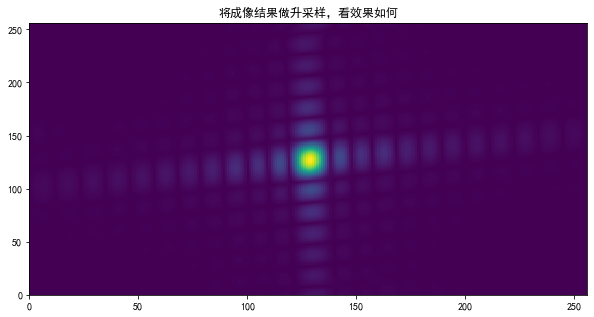

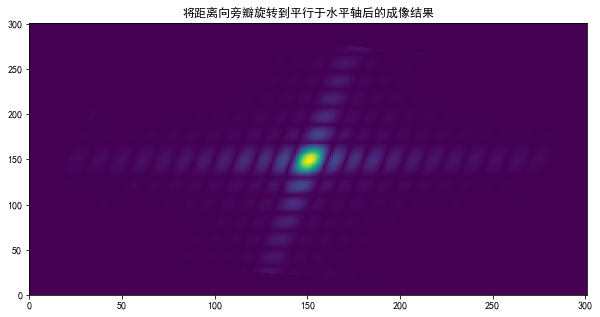

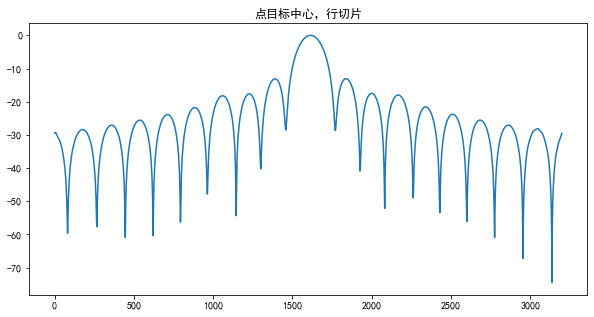

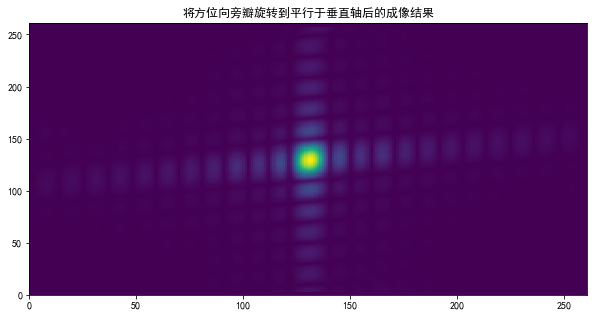

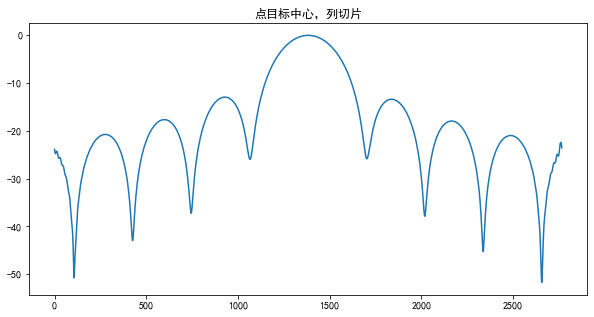

In [16]:
##
# 下面通过调用函数，得到三个点目标各自的切片，并进行升采样
# 同时对点目标中心做距离向切片，方位向切片
# 计算出相应的指标：PSLR，ISLR，IRW

NN = 20;
# 分别得到每个点目标的切片放大；行切片、列切片；和相应的指标
# 目标1，点目标中心在 （ tg_1_x，tg_1_y ）
tg_1_x = 96;
tg_1_y = round(N_rg/2);
target_area = s_ac[tg_1_x-NN-1:tg_1_x+NN,tg_1_y-NN-1:tg_1_y+NN]
# np.savetxt('target_area.txt',target_area)
target_1 = target_analysis_2( target_area,Fr,Fa,Vr);

# 目标2，点目标中心在 （tg_2_x，target_2_y）
tg_2_x = tg_1_x + delta_R1/Vr*Fa;
tg_2_y = tg_1_y;
# target_2 = target_analysis_2( s_ac(tg_2_x-NN:tg_2_x+NN,tg_2_y-NN:tg_2_y+NN),Fr,Fa,Vr);

# 目标3，点目标中心在（tg_3_x，tg_3_y）
# tg_3_x = tg_2_x + delta_R2*tan(sita_r_c)/Vr*Fa;
# tg_3_x = fix(tg_3_x);
# tg_3_y = tg_2_y + 2*delta_R2/c*Fr;
# target_3 = target_analysis_2( s_ac(tg_3_x-NN:tg_3_x+NN,tg_3_y-NN:tg_3_y+NN),Fr,Fa,Vr);